In [187]:
chrom = '22'
peak_start, peak_end = 48609694,48648842

In [60]:
from os import listdir
import gzip
import numpy as np
from scipy import sparse

# load genotypes
gen_files = sorted([f for f in listdir('split_gen') if ('chr.%s' % chrom) in f and 'gen.npz' in f])
whole_chrom = sparse.hstack([sparse.load_npz('split_gen/%s' % gen_file) for gen_file in gen_files])
m, n = whole_chrom.shape
print(m, n)

# pull indices of snps
variant_file = 'split_gen/chr.%s.gen.variants.txt.gz' % chrom
snp_indices = []
snp_positions_all = []
with gzip.open(variant_file, 'rt') as f:
    for i, line in enumerate(f):
        pieces = line.strip().split('\t')
        if len(pieces[3]) == 1 and len(pieces[4]) == 1 and pieces[3] != '.' and pieces[4] != '.':
            snp_indices.append(i)
            snp_positions_all.append(int(pieces[1]))
snp_positions_all = np.asarray(snp_positions_all)

whole_chrom = whole_chrom[:, snp_indices]
m, n = whole_chrom.shape
print(m, n)

4610 1096535
4610 1004649


In [61]:
sample_file = 'split_gen/chr.%s.gen.samples.txt' % chrom
with open(sample_file, 'r') as f:
    individual_to_index = dict([(x.strip(), i) for i, x in enumerate(f)])

In [62]:
ped_file = '160826.ped'
# Affection (0=unknown; 1=unaffected; 2=affected)
id_to_affected = dict()
id_to_sex = dict()
with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if len(pieces) >= 6:
            fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
            id_to_affected[child_id] = disease_status
            id_to_sex[child_id] = sex
            id_to_sex[f_id] = '1'
            id_to_sex[m_id] = '2'
            
male_indices = [i for x, i in individual_to_index.items() if x in id_to_sex and id_to_sex[x] == '1']
female_indices = [i for x, i in individual_to_index.items() if x in id_to_sex and id_to_sex[x] != '1']
affected_indices = [i for x, i in individual_to_index.items() if x in id_to_affected and id_to_affected[x] == '2']
unaffected_indices = [i for x, i in individual_to_index.items() if x in id_to_affected and id_to_affected[x] != '2']
print('Male', len(male_indices), 'Female', len(female_indices))
print('Affected', len(affected_indices), 'Unaffected', len(unaffected_indices))

Male 2823 Female 1773
Affected 2182 Unaffected 2414


In [110]:
from collections import defaultdict
from collections import namedtuple


phase_dir = 'sherlock_phased'

Deletion = namedtuple('Deletion', ['family', 'chrom', 
                                   'start_pos', 'end_pos', 'start_index', 'end_index', 'length',
                                   'inheritance_state', 'individuals',
                                   'doubledel', 'singledel', 'nodel',
                                   'singledel_maternal', 'singledel_paternal'])


# load deletions from all chromosomes
deletions = []
family_to_individuals = dict()
family_to_indices = dict()

fams = set()
for j in range(3, 7):
    with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r')  as f:
        next(f) # skip header
        for line in f:
            pieces = line.strip().split('\t')
            family_key = pieces[0]
            family_to_individuals[family_key] = pieces[1:(1+j)]
            family_to_indices[family_key] = [int(x) for x in pieces[(1+j):]]
            fams.add(family_key)
                
    # load deletions
    with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as f:
        next(f) # skip header
        for line in f:
            pieces = line.strip().split('\t')
            family_key = pieces[0]
            inheritance_state = [int(x) for x in pieces[2:(2+(j*2))]]
            start_pos, end_pos, start_index, end_index = [int(x) for x in pieces[(2+(j*2)):(6+(j*2))]]
            length = end_pos - start_pos + 1
            individuals = family_to_individuals[family_key]
                
            # there was an inherited deletion
            doubledel, singledel, nodel = [], [], []
            singledel_mat, singledel_pat = [], []
                        
            # children
            for k, child_id in enumerate(individuals[2:]):
                mat, pat = inheritance_state[(4+(2*k)):(6+(2*k))]
                    
                if inheritance_state[mat] == 1 and inheritance_state[2+pat] == 1:
                    doubledel.append(child_id)
                elif inheritance_state[mat] == 1:
                    singledel.append(child_id)
                    singledel_mat.append(child_id)
                elif inheritance_state[2+pat] == 1:
                    singledel.append(child_id)
                    singledel_pat.append(child_id)
                else:
                    nodel.append(child_id)
                    
            deletions.append(Deletion(family_key, chrom,
                                          start_pos, end_pos, start_index, end_index, length,
                                          inheritance_state, individuals,
                                          doubledel, singledel, nodel,
                                          singledel_mat, singledel_pat))
                
print(chrom, 'Num fams', len(fams))
                    
print('deletions', len(deletions), 
      'maternal', sum([sum(x.inheritance_state[:2]) for x in deletions]), 
      'paternal', sum([sum(x.inheritance_state[2:4]) for x in deletions]))

22 Num fams 862
deletions 288712 maternal 289339 paternal 294796


In [170]:
included_in_analysis = sum(family_to_indices.values(), [])
child_indices = sum([x[2:] for x in family_to_indices.values()], [])
parent_indices = sum([x[:2] for x in family_to_indices.values()], [])
affected_children_indices = sorted(set(affected_indices) & set(child_indices))
unaffected_children_indices = sorted(set(unaffected_indices) & set(child_indices))
mother_indices = sorted(set(parent_indices) & set(female_indices))
father_indices = sorted(set(parent_indices) & set(male_indices))

In [196]:
indices = np.where((snp_positions_all >= peak_start) & (snp_positions_all <= peak_end))[0][1000:]
print(indices)
gen = whole_chrom[:, indices].A

[920034 920035 920036 920037 920038 920039 920040 920041 920042 920043
 920044 920045 920046 920047 920048 920049 920050 920051 920052 920053
 920054 920055 920056 920057 920058 920059 920060 920061 920062 920063
 920064 920065 920066 920067 920068 920069 920070 920071 920072 920073
 920074 920075 920076 920077 920078 920079 920080 920081 920082 920083
 920084 920085 920086 920087 920088 920089 920090 920091 920092 920093
 920094 920095 920096 920097 920098 920099 920100 920101 920102 920103
 920104 920105 920106 920107 920108 920109 920110 920111 920112 920113
 920114 920115 920116 920117 920118 920119 920120 920121 920122 920123
 920124 920125 920126 920127 920128 920129 920130 920131 920132 920133
 920134 920135 920136 920137 920138 920139 920140 920141 920142 920143
 920144 920145 920146 920147 920148 920149 920150 920151 920152 920153
 920154 920155 920156 920157 920158 920159 920160 920161 920162 920163
 920164 920165 920166 920167 920168 920169 920170 920171 920172 920173
 92017

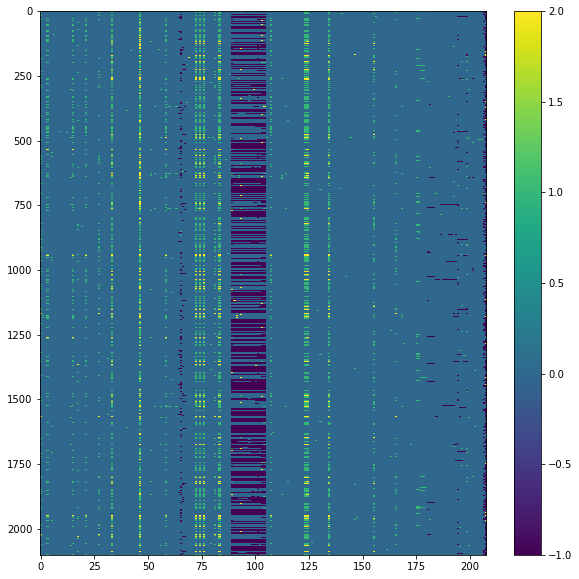

In [197]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(gen[affected_children_indices + unaffected_children_indices, :], aspect='auto')
plt.colorbar()
plt.show()

Num peak dels 1272
Families 862


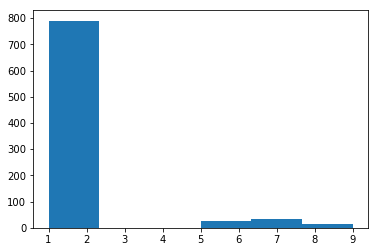

In [198]:
peak_dels = [d for d in deletions if (d.start_pos >= peak_start and d.start_pos <= peak_end) or (d.end_pos >= peak_start and d.end_pos <= peak_end) or (d.start_pos <= peak_start and d.end_pos >= peak_end)]
print('Num peak dels', len(peak_dels))

family_to_dels = defaultdict(list)
for d in peak_dels:
    family_to_dels[d.family].append(d)
    
print('Families', len(family_to_dels))
plt.hist([len(v) for v in family_to_dels.values()], bins=6)
plt.show()

In [199]:
min_index = indices[0]
delmatrix = np.zeros((m, indices.shape[0]))-1
for d in peak_dels:
    delmatrix[individual_to_index[d.individuals[0]], (d.start_index-min_index):(d.end_index+1-min_index)] = sum(d.inheritance_state[:2])
    delmatrix[individual_to_index[d.individuals[1]], (d.start_index-min_index):(d.end_index+1-min_index)] = sum(d.inheritance_state[2:4])
    
    # children
    for k, child_id in enumerate(d.individuals[2:]):
        mat, pat = d.inheritance_state[(4+(2*k)):(6+(2*k))]
                    
        delmatrix[individual_to_index[d.individuals[k+2]], (d.start_index-min_index):(d.end_index+1-min_index)] = d.inheritance_state[mat] + d.inheritance_state[2+pat]

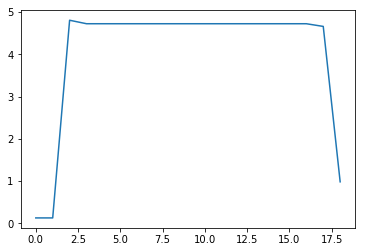

In [210]:
from scipy.stats import chi2_contingency

pvalues = np.zeros((indices.shape[0]))
for i in range(indices.shape[0]):
    con = np.asarray([[np.sum(delmatrix[affected_children_indices, i]==2), np.sum(delmatrix[unaffected_children_indices, i]==2)],
          [np.sum(delmatrix[affected_children_indices, i]==1), np.sum(delmatrix[unaffected_children_indices, i]==1)],
          [np.sum(delmatrix[affected_children_indices, i]==0), np.sum(delmatrix[unaffected_children_indices, i]==0)]])
    con = con[np.ix_(np.sum(con, axis=1)>0, np.sum(con, axis=0)>0)]
    
    if con.shape[0] > 1 and con.shape[1] > 1:
        pvalue = chi2_contingency(con, correction=False)[1]
    else:
        pvalue = 1
    pvalues[i] = pvalue
    
plt.plot(-np.log10(pvalues[87:106]))
plt.show()

In [211]:
print(snp_positions_all[indices[87]], snp_positions_all[indices[106]])

48645115 48645745


In [201]:
i = 100
c = np.asarray([[np.sum(delmatrix[affected_children_indices, i]==2), np.sum(delmatrix[unaffected_children_indices, i]==2)],
          [np.sum(delmatrix[affected_children_indices, i]==1), np.sum(delmatrix[unaffected_children_indices, i]==1)],
          [np.sum(delmatrix[affected_children_indices, i]==0), np.sum(delmatrix[unaffected_children_indices, i]==0)]])
print(c)
print(c/np.sum(c, axis=0))

c = np.asarray([[np.sum(delmatrix[mother_indices, i]==2), np.sum(delmatrix[father_indices, i]==2)],
          [np.sum(delmatrix[mother_indices, i]==1), np.sum(delmatrix[father_indices, i]==1)],
          [np.sum(delmatrix[mother_indices, i]==0), np.sum(delmatrix[father_indices, i]==0)]])
print(c)
print(c/np.sum(c, axis=0))


[[ 131   56]
 [  29   10]
 [1562  313]]
[[ 0.07607433  0.14775726]
 [ 0.01684088  0.02638522]
 [ 0.90708479  0.82585752]]
[[ 47  40]
 [ 25  32]
 [786 790]]
[[ 0.05477855  0.04640371]
 [ 0.02913753  0.03712297]
 [ 0.91608392  0.91647332]]


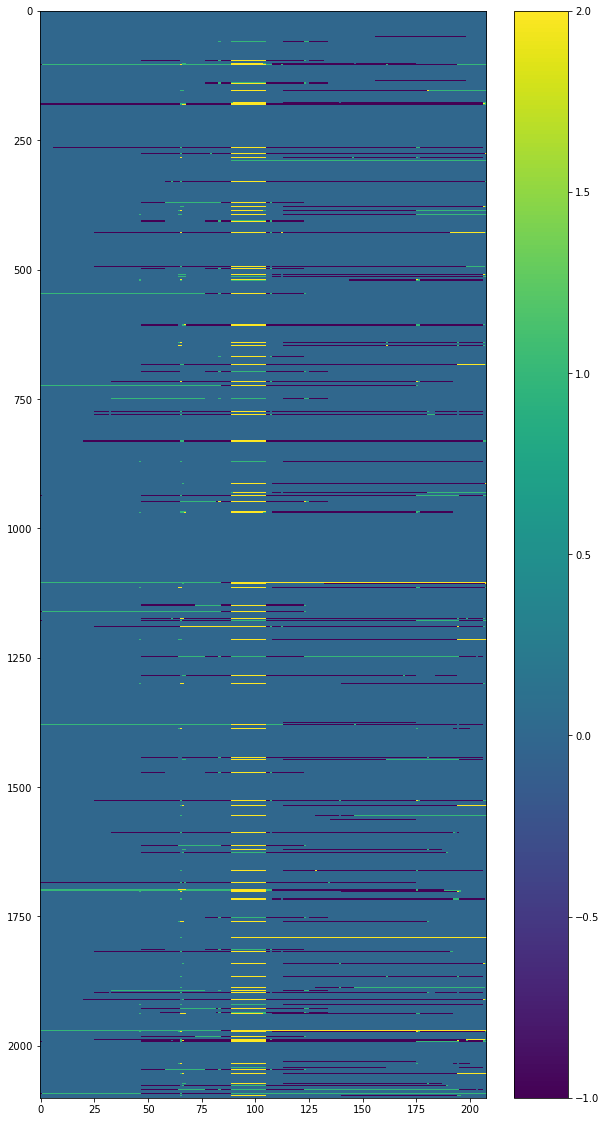

In [202]:
plt.figure(figsize=(10, 20))
plt.imshow(delmatrix[affected_children_indices + unaffected_children_indices, :], aspect='auto')
plt.colorbar()
plt.show()

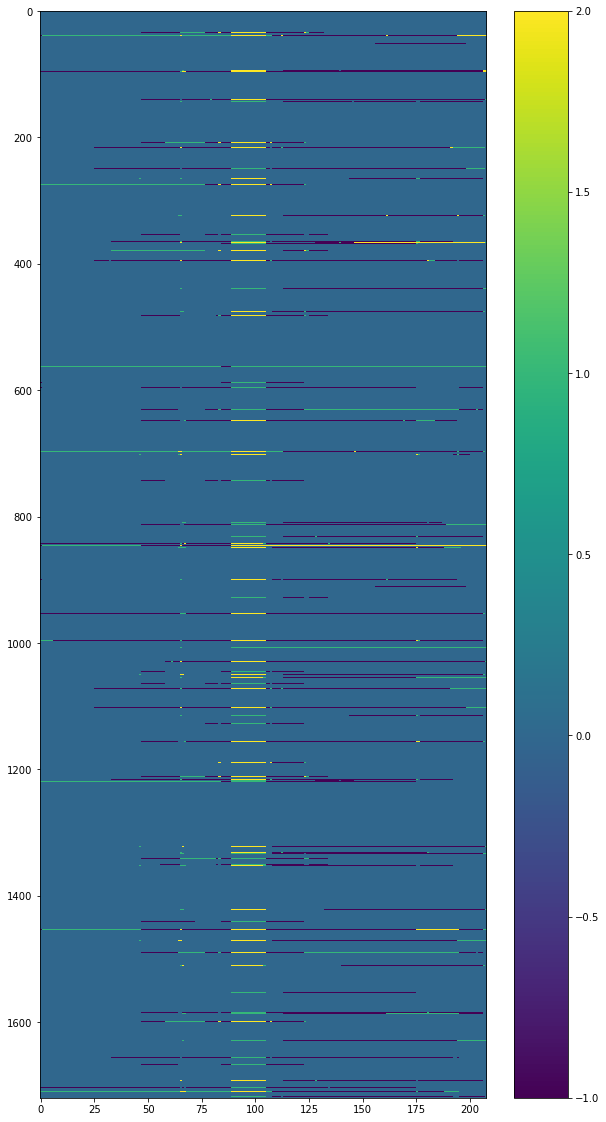

In [203]:
plt.figure(figsize=(10, 20))
plt.imshow(delmatrix[mother_indices + father_indices, :], aspect='auto')
plt.colorbar()
plt.show()

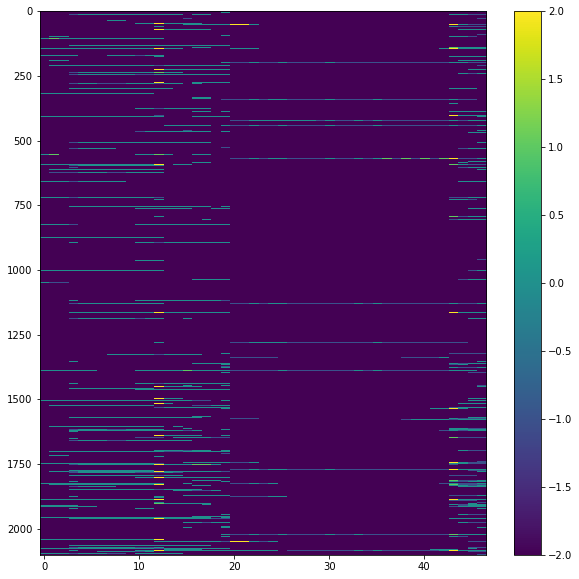

In [186]:
a = np.zeros(gen.shape)-2
a[delmatrix==1] = gen[delmatrix==1]
plt.figure(figsize=(10, 10))
plt.imshow(a[affected_children_indices+unaffected_children_indices, :], aspect='auto')
plt.colorbar()
plt.show()